In [1]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 8.6 MB/s eta 0:00:00


In [12]:
import numpy as np
import numpy.random as random

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ot

In [3]:
def clamp(value, min_val, max_val):
    return np.maximum(min_val, np.minimum(value, max_val))

In [4]:
def sdf_box(x, b=[0.7,0.7]):
    d = np.abs(x)-b
    max_d = np.maximum(d, 0.0)
    length_d = np.sqrt(np.sum(max_d**2, 1))
    return length_d + np.minimum(np.maximum(d[:,0], d[:,1]), 0.0)

In [5]:
def sdf_pentagon(p,r=0.7):
  k=np.array([0.809016994,0.587785252,0.726542528]);
  p[:, 0]=np.abs(p[:, 0])
  l=np.array([-k[0],k[1]])
  m=np.array([k[0],k[1]])
  p -= 2.0 * np.minimum(np.dot(p, l), 0.0)[:, np.newaxis] * l
  p -= 2.0 * np.minimum(np.dot(p, m), 0.0)[:, np.newaxis] * m
  p[:,1]-=r
  p[:,0]-=clamp(p[:, 0],-r*k[2],r*k[2])
  max_p = np.maximum(p, 0.0)
  return np.linalg.norm(p,axis=1)*np.sign(p[:,1])

In [6]:
def gen_grid(resolution, low=-1.0, high=1.0):
    idx = np.linspace(low, high, num=resolution)
    x, y = np.meshgrid(idx, idx)
    V = np.concatenate((x.reshape((-1,1)), y.reshape((-1,1))), 1)

    return V

In [11]:
def space_time_blending(f1, f2, t, x, a0=1.0, a1=1.0, a2=1.0):
    f1x = f1(x)
    f2x = f2(x)

    #f1x_cyl = np.minimum(f1x, -t) # needs R-functions to work properly
    f1x_cyl = r_intersection(f1x, -t)
    #f2x_cyl = np.minimum(f2x, (t-1)) # needs R-functions to work properly
    f2x_cyl = r_intersection(f2x, (t-1))

    disp = a0 / (1.0 + (f1x_cyl/a1)**2 + (f2x_cyl/a2)**2)
    r_uni = r_union(f1x_cyl, f2x_cyl)

    return r_uni + disp

In [17]:
def linear_morphing(f1, f2, t, x):
    return (1-t)*f1(x) + t*f2(x)

In [7]:
def sample_and_normalize(f, grid, grid_size):
    '''
    Sample f on the grid and normalize it.
    Assume f>0 outside and <0 inside.
    '''
    print(grid.shape)
    fv = f(grid)
    print(fv.shape)

    # >0 inside
    fv = -fv

    # f is the characteristic function for {f>0}
    fv[fv>=0.0] = 1.0
    fv[fv<0.0] = 0.0

    total_sum = np.sum(fv)
    if total_sum > 0:
        fv = fv / total_sum
    else:
        raise ValueError("The sum of the function values is zero; normalization is not possible.")

    # reshape to have the same shape as grid
    fv = fv.reshape(grid_size, grid_size)

    return fv

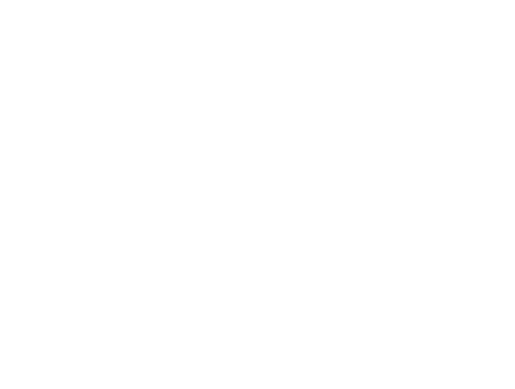

In [19]:
grid_size = 64

fig = plt.figure()
x = gen_grid(grid_size,-2.0,2.0)

def animate(t):
    plt.cla()
    out = linear_morphing(sdf_box, sdf_pentagon ,np.array([t]), x)
    #levels = np.linspace(-1.0, 1.0, 21)
    #im = plt.contourf(out.reshape(grid_size, grid_size), levels = levels)
    im = plt.contour(out.reshape(grid_size, grid_size), levels = [0.0])
    plt.axis('equal')
    plt.axis("off")
    return im

anim = animation.FuncAnimation(fig, animate, frames=np.linspace(0, 1, 50), interval=50)
anim.save("linear_morphing.mp4")